# Stability Module Guide - Data Drift Analysis

## Overview

The `stability.py` module is a comprehensive tool for analyzing data drift and model stability between two datasets, particularly useful for monitoring machine learning models in production environments. This module is essential for detecting when the underlying data distribution changes over time, which can significantly impact model performance.

### Main Functions Provided:

1. **`calculate_psi(expected, actual)`**: Calculates the Population Stability Index (PSI) between two distributions. This is the primary metric for measuring distribution shift between training and validation/test datasets.

2. **`calculate_feature_drift(train_df, test_df, numerical_cols, categorical_cols)`**: Performs comprehensive drift analysis for individual features using appropriate statistical tests for numerical and categorical variables.

3. **`stability_summary(score_train, score_test, train_df, test_df, numerical_cols, categorical_cols)`**: Provides an overall stability assessment that combines PSI scores with feature-level drift analysis to give a holistic view of data stability.

4. **Visualization functions**: A suite of plotting functions including `plot_psi_histogram()`, `plot_numerical_drift()`, `plot_categorical_drift()`, and `plot_top_feature_drifts()` for visual analysis of drift patterns.

### Key Statistical Concepts:

**Population Stability Index (PSI) Interpretation:**
- **PSI < 0.1**: No significant drift detected. The distributions are essentially stable and no immediate action is required.
- **0.1 ≤ PSI < 0.25**: Moderate drift detected. This indicates some changes in the data distribution that warrant investigation and enhanced monitoring.
- **PSI ≥ 0.25**: Severe drift detected. This level of drift typically requires immediate model retraining or recalibration.

**Statistical Tests for Feature Drift:**
- **Kolmogorov-Smirnov (KS) Test**: Used for numerical features to compare distributions. A p-value < 0.05 indicates statistically significant drift.
- **Chi-square Test**: Applied to categorical features to test independence between training and test distributions. A p-value < 0.05 suggests significant drift in category proportions.

## 1. Setup and Data Loading

This section imports the necessary libraries and loads the required data for stability analysis. We will be working with the Level 3 (L3) ExtraTree stacking model, which represents the final ensemble model in our credit risk modeling pipeline.

The data loading process involves:
- **Processed datasets**: Training and test data that have undergone feature engineering and encoding
- **Model predictions**: Out-of-fold (OOF) predictions for the training set and standard predictions for the test set
- **Feature identification**: Automatic detection of numerical features (categorical features have been encoded)

In [2]:
# Import necessary libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Add path to import stability module
sys.path.append('../src/validation')
from stability import (
    calculate_psi, 
    calculate_feature_drift, 
    stability_summary,
    plot_psi_histogram,
    plot_numerical_drift,
    plot_categorical_drift,
    plot_top_feature_drifts
)

print("Stability module imported successfully!")

# Load L3 model data
try:
    # Load processed data
    train_df = pd.read_csv('../data/processed/train_processed.csv')
    test_df = pd.read_csv('../data/processed/test_processed.csv')
    
    # Load L3 model predictions
    train_predictions = pd.read_csv('../models/l3_stacking/l3_extratree_oof_predictions.csv')
    test_predictions = pd.read_csv('../models/l3_stacking/l3_extratree_test_predictions.csv')
    
    # Use correct column names from the CSV files
    train_scores = train_predictions['oof_preds'].values  # Changed from 'prediction' to 'oof_preds'
    test_scores = test_predictions['test_preds'].values   # Changed from 'prediction' to 'test_preds'
    
    print("Data loaded successfully:")
    print(f"   Train dataset: {len(train_df)} samples, {len(train_df.columns)} features")
    print(f"   Test dataset: {len(test_df)} samples, {len(test_df.columns)} features")
    print(f"   Model predictions: Train={len(train_scores)}, Test={len(test_scores)}")
    
    # Identify numerical columns (all features are numerical after encoding)
    numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
    # Remove target/ID columns if present
    for col in ['TARGET', 'SK_ID_CURR', 'target', 'id', 'ID']:
        if col in numerical_cols:
            numerical_cols.remove(col)
    
    print(f"   Numerical features identified: {len(numerical_cols)}")
    
except Exception as e:
    print(f"Error loading data: {e}")

Stability module imported successfully!
Data loaded successfully:
   Train dataset: 307511 samples, 49 features
   Test dataset: 48744 samples, 48 features
   Model predictions: Train=307511, Test=48744
   Numerical features identified: 48
Data loaded successfully:
   Train dataset: 307511 samples, 49 features
   Test dataset: 48744 samples, 48 features
   Model predictions: Train=307511, Test=48744
   Numerical features identified: 48


## 2. Population Stability Index (PSI)

The Population Stability Index (PSI) is a statistical measure used to quantify the degree of shift between two distributions. It is particularly valuable in model validation and monitoring scenarios where we need to assess whether the current data distribution is similar to the baseline (training) distribution.

### Mathematical Foundation

The PSI is calculated using the following formula:

**PSI = Σ (P_actual - P_expected) × ln(P_actual/P_expected)**

Where:
- **P_expected**: Proportion of observations in each bin for the baseline dataset (typically training data)
- **P_actual**: Proportion of observations in each bin for the comparison dataset (typically validation/test data)
- The summation is performed across all bins (typically 10 bins using quantile-based binning)

### Interpretation Thresholds

The PSI values are interpreted using industry-standard thresholds:

- **PSI < 0.1**: **No significant drift** - The distribution is stable and similar to the baseline. No immediate action required.
- **0.1 ≤ PSI < 0.25**: **Moderate drift** - Some shift in distribution detected. Enhanced monitoring and investigation recommended.
- **PSI ≥ 0.25**: **Severe drift** - Significant distribution shift detected. Model retraining or recalibration typically required.

### Practical Application

PSI is commonly used to:
1. Monitor model score distributions over time
2. Validate that test data is representative of training data
3. Trigger model retraining workflows in production systems
4. Assess the stability of individual features

PSI Score: 0.0125
Drift level: LOW - No significant drift


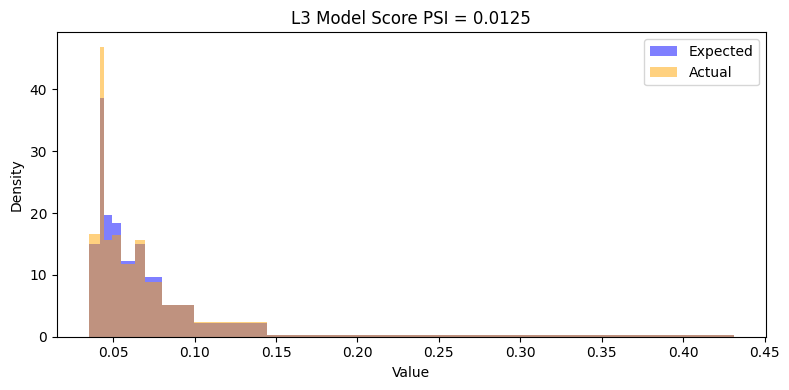

In [3]:
# Calculate PSI for L3 model scores
psi_score = calculate_psi(train_scores, test_scores)
print(f"PSI Score: {psi_score:.4f}")

# Interpret drift level
if psi_score < 0.1:
    drift_level = "LOW - No significant drift"
elif psi_score < 0.25:
    drift_level = "MODERATE - Monitoring needed"  
else:
    drift_level = "HIGH - Immediate action required"

print(f"Drift level: {drift_level}")

# Plot PSI histogram
plot_psi_histogram(
    train_scores, test_scores, 
    title=f"L3 Model Score PSI = {psi_score:.4f}"
)
plt.show()

## 3. Feature Drift Analysis

Feature drift analysis examines individual features to detect changes in their distributions between training and test datasets. The `calculate_feature_drift()` function employs different statistical methods depending on the feature type.

### Methods for Numerical Features

**1. Kolmogorov-Smirnov (KS) Test**
- **Purpose**: Tests whether two samples come from the same continuous distribution
- **Null Hypothesis**: Both datasets follow the same distribution
- **Test Statistic**: Maximum distance between the cumulative distribution functions (CDFs)
- **Interpretation**: A p-value < 0.05 indicates statistically significant drift
- **Advantages**: Non-parametric, sensitive to any type of distribution difference

**2. Wasserstein Distance (Earth Mover's Distance)**
- **Purpose**: Measures the minimum effort required to transform one distribution into another
- **Interpretation**: Higher values indicate greater distributional differences
- **Advantages**: Provides an intuitive measure of "distance" between distributions

**3. Mean Difference Percentage**
- **Purpose**: Quantifies the relative change in central tendency
- **Formula**: |mean_test - mean_train| / |mean_train|
- **Interpretation**: Values > 10% typically warrant investigation

### Methods for Categorical Features

**1. Chi-square Test of Independence**
- **Purpose**: Tests whether the frequency distribution of categories is independent of the dataset (train vs test)
- **Null Hypothesis**: Category proportions are the same in both datasets
- **Requirements**: Sufficient sample size in each category (typically ≥5 observations)
- **Interpretation**: A p-value < 0.05 suggests significant drift in category distributions

**2. Jensen-Shannon Divergence**
- **Purpose**: Measures the similarity between two probability distributions
- **Range**: 0 to 1, where 0 indicates identical distributions and 1 indicates completely different distributions
- **Advantages**: Symmetric, bounded, and provides an intuitive similarity score

Feature drift analysis completed:
   Checked features: 10
   Skipped features: 0

Drift Results:
  EXT_SOURCE_2: KS=0.0300, p=0.0002, Drift=Yes
  EXT_SOURCE_3: KS=0.0330, p=0.0000, Drift=Yes
  EXT_SOURCE_1: KS=0.0685, p=0.0000, Drift=Yes
  CREDIT_TO_ANNUITY: KS=0.3231, p=0.0000, Drift=Yes
  CODE_GENDER: KS=0.0055, p=0.9982, Drift=No
  DAYS_EMPLOYED: KS=0.0202, p=0.0338, Drift=Yes
  CREDIT_GOODS_RATIO: KS=0.0860, p=0.0000, Drift=Yes
  NAME_EDUCATION_TYPE: KS=0.0114, p=0.5343, Drift=No
  PREV_NAME_CONTRACT_STATUS__lambda_: KS=0.0777, p=0.0000, Drift=Yes
  DAYS_BIRTH: KS=0.0203, p=0.0325, Drift=Yes

Plotting top drifted features:
Numerical drift: CREDIT_TO_ANNUITY (KS=0.323)
Numerical drift: CREDIT_GOODS_RATIO (KS=0.086)
Numerical drift: CREDIT_GOODS_RATIO (KS=0.086)


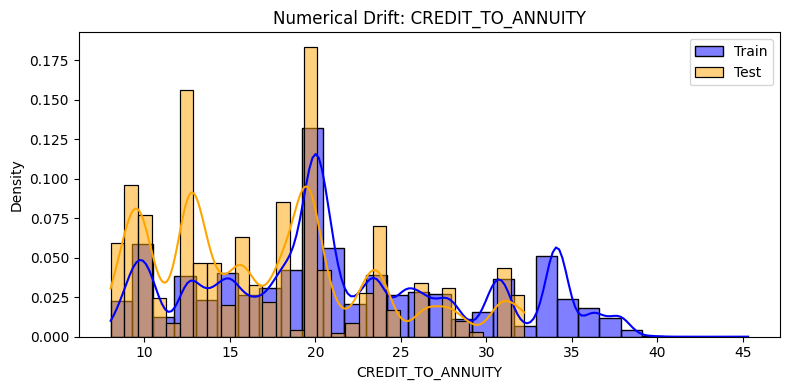

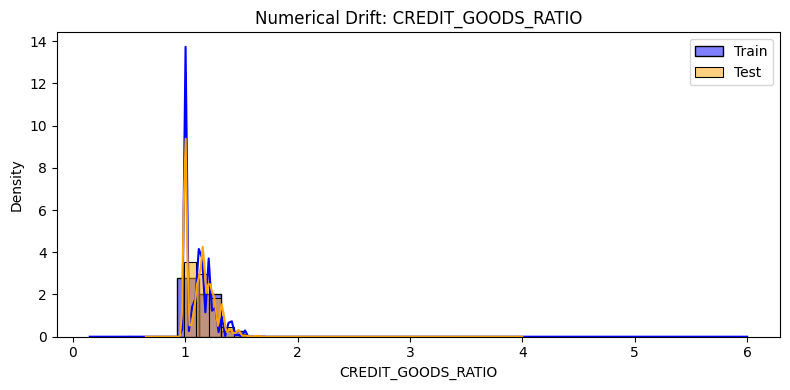

In [4]:
# Analyze feature drift using the stability module
drift_result = calculate_feature_drift(
    train_df, test_df, 
    numerical_cols=numerical_cols[:10],  # Analyze first 10 features
    categorical_cols=[],  # No categorical features after encoding
    verbose=True
)

print("Feature drift analysis completed:")
print(f"   Checked features: {drift_result['checked_features']}")
print(f"   Skipped features: {drift_result['skipped_features']}")

# Display drift results
drift_report = drift_result['drift_report']
print("\nDrift Results:")
for feature, metrics in drift_report.items():
    if metrics['type'] == 'numerical':
        ks_stat = metrics['KS_stat']
        ks_pval = metrics['KS_pvalue']
        drift_status = "Yes" if ks_pval < 0.05 else "No"
        print(f"  {feature}: KS={ks_stat:.4f}, p={ks_pval:.4f}, Drift={drift_status}")

# Plot top drifted features
print("\nPlotting top drifted features:")
plot_top_feature_drifts(train_df, test_df, drift_report, top_n=2)
plt.show()

## 4. Overall Stability Summary

The `stability_summary()` function provides a comprehensive assessment that combines model-level and feature-level stability metrics into a unified evaluation framework. This function is particularly valuable for automated monitoring systems and executive reporting.

### Components of the Stability Summary

**1. Model Score PSI Analysis**
- Calculates the PSI for model predictions between training and test datasets
- Provides severity classification based on standard industry thresholds
- Essential for understanding whether the model's output distribution has shifted

**2. Feature Drift Aggregation** 
- Counts the number of features showing statistically significant drift
- Calculates the percentage of features affected by drift
- Identifies specific features contributing to instability

**3. Overall Risk Assessment**
- Combines PSI scores with feature drift percentages
- Applies business rules to classify overall risk level (Low/Medium/High)
- Provides actionable recommendations based on the assessment

### Risk Classification Logic

The severity classification uses the following business rules:
- **Low Risk**: PSI < 0.1 AND < 10% of features show drift
- **Medium Risk**: 0.1 ≤ PSI < 0.25 OR 10-30% of features show drift  
- **High Risk**: PSI ≥ 0.25 OR > 30% of features show drift

This multi-dimensional approach ensures that both model-level and data-level changes are captured in the risk assessment.

In [6]:
# Generate overall stability summary
summary = stability_summary(
    score_train=train_scores,
    score_test=test_scores, 
    train_df=train_df,
    test_df=test_df,
    numerical_cols=numerical_cols[:10],  # Analyze first 10 features
)

print("STABILITY SUMMARY:")
print(f"   Score PSI: {summary['Score_PSI']}")
print(f"   PSI Severity: {summary['PSI_Severity']}")
print(f"   Features with drift: {summary['Total_Drift_Features']}")
print(f"   Drift percentage: {summary['Drift_Score_Percentage']}%")

if summary['Drift_Flag_Features']:
    print("\nFEATURES WITH DRIFT:")
    for feature in summary['Drift_Flag_Features']:
        print(f"   - {feature}")
else:
    print("\nNo features with significant drift detected")

# Risk assessment
if summary['Score_PSI'] >= 0.25 or summary['Drift_Score_Percentage'] > 30:
    print("\nHIGH RISK - Model retraining recommended")
elif summary['Score_PSI'] >= 0.1 or summary['Drift_Score_Percentage'] > 10:
    print("\nMEDIUM RISK - Enhanced monitoring needed")
else:
    print("\nLOW RISK - Continue normal monitoring")

STABILITY SUMMARY:
   Score PSI: 0.0125
   PSI Severity: Low
   Features with drift: 0
   Drift percentage: 0.0%

No features with significant drift detected

LOW RISK - Continue normal monitoring


## 5. Visualization Functions

The stability module includes a comprehensive suite of visualization functions designed to provide intuitive graphical representations of drift patterns. These visualizations are essential for stakeholder communication and detailed drift analysis.

### Available Plotting Functions

**1. `plot_psi_histogram(expected, actual, title)`**
- **Purpose**: Creates overlapping histograms to visualize distribution differences for PSI analysis
- **Use Case**: Comparing model score distributions between training and test datasets
- **Output**: Dual-histogram plot with density curves showing distributional overlap and separation

**2. `plot_numerical_drift(train_col, test_col, feature_name)`**
- **Purpose**: Generates histogram and kernel density estimation (KDE) plots for numerical features
- **Features**: Includes both histogram bars and smooth density curves for better pattern recognition
- **Use Case**: Detailed analysis of individual numerical feature drift patterns

**3. `plot_categorical_drift(train_counts, test_counts, feature_name)`**
- **Purpose**: Creates side-by-side bar charts comparing categorical distributions
- **Features**: Handles category frequency comparisons and automatically limits to top N categories
- **Use Case**: Visual comparison of category proportions between datasets

**4. `plot_top_feature_drifts(train_df, test_df, drift_report, top_n)`**
- **Purpose**: Automatically identifies and plots the most severely drifted features
- **Intelligence**: Ranks features by their drift statistics and selects the most problematic ones
- **Use Case**: Quick identification of features requiring immediate attention

### Visualization Best Practices

These plots are designed for:
- **Executive reporting**: Clear, interpretable visuals for business stakeholders
- **Technical analysis**: Detailed statistical information for data scientists
- **Production monitoring**: Automated generation for regular stability reports
- **Model validation**: Visual evidence for model performance documentation

1. PSI Histogram Visualization:


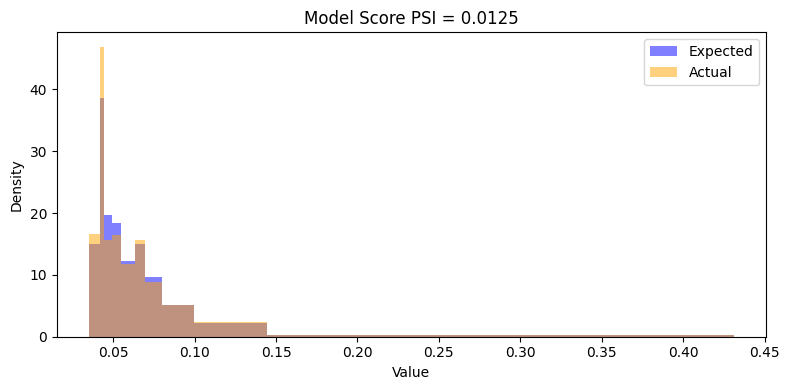


2. Individual Feature Drift Analysis:


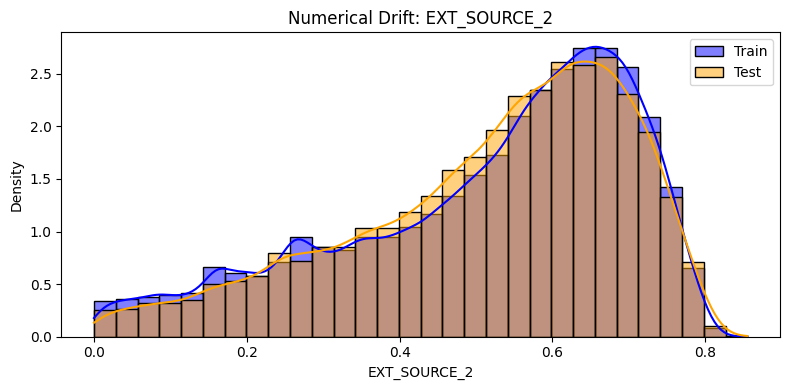


3. Automated Top Feature Drift Plots:
Numerical drift: CREDIT_TO_ANNUITY (KS=0.323)
Numerical drift: CREDIT_GOODS_RATIO (KS=0.086)
Numerical drift: CREDIT_GOODS_RATIO (KS=0.086)
Numerical drift: PREV_NAME_CONTRACT_STATUS__lambda_ (KS=0.078)
Numerical drift: PREV_NAME_CONTRACT_STATUS__lambda_ (KS=0.078)


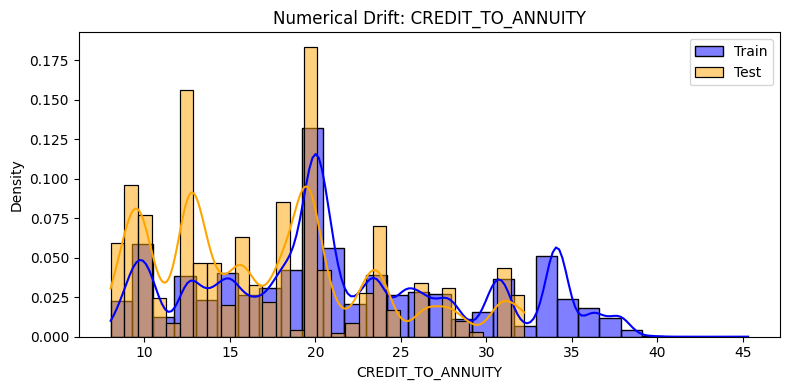

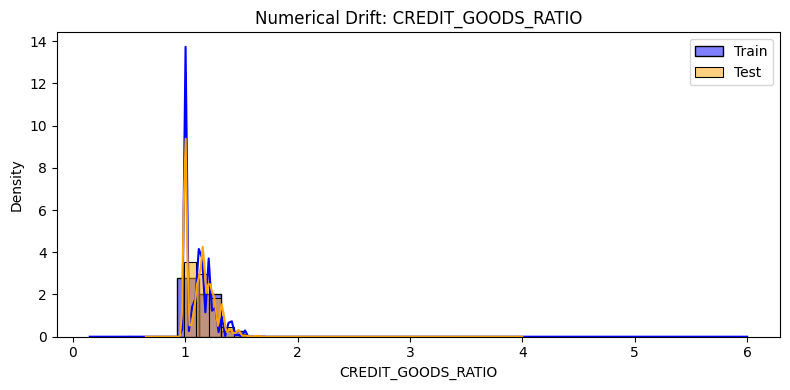

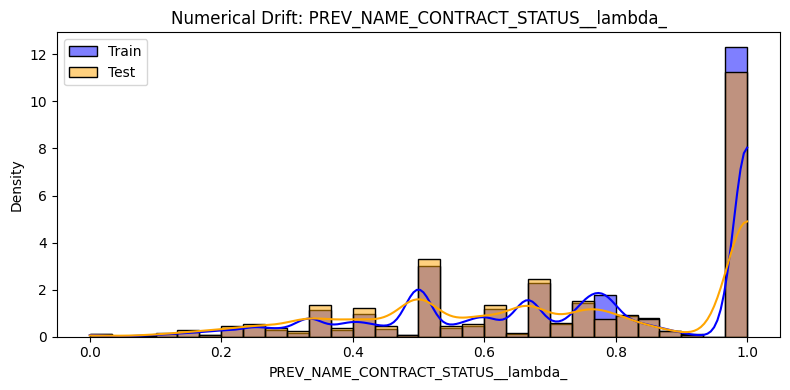

Visualization demonstration completed!


In [7]:
# Demo visualization functions from the stability module

# 1. PSI histogram for model scores
print("1. PSI Histogram Visualization:")
plot_psi_histogram(train_scores, test_scores, title=f"Model Score PSI = {psi_score:.4f}")
plt.show()

# 2. Individual numerical feature drift
print("\n2. Individual Feature Drift Analysis:")
# Pick first feature for demo
feature_name = numerical_cols[0]
plot_numerical_drift(
    train_df[feature_name].dropna(), 
    test_df[feature_name].dropna(), 
    feature_name
)
plt.show()

# 3. Top feature drifts (automated)
print("\n3. Automated Top Feature Drift Plots:")
plot_top_feature_drifts(train_df, test_df, drift_report, top_n=3)
plt.show()

print("Visualization demonstration completed!")

## 6. Summary and Implementation Guide

### Core Functions Overview

This notebook has demonstrated the four primary functions of the `stability.py` module:

**1. `calculate_psi(expected, actual, buckets=10, return_details=False)`**
- Calculates Population Stability Index between two distributions
- Uses quantile-based binning for robust comparison
- Returns PSI score and optionally detailed bin-level information
- Essential for model score stability monitoring

**2. `calculate_feature_drift(train_df, test_df, numerical_cols=[], categorical_cols=[], sample_size=10000, verbose=False)`**
- Performs comprehensive drift analysis across feature types
- Applies appropriate statistical tests (KS for numerical, Chi-square for categorical)
- Handles large datasets through intelligent sampling
- Returns detailed drift metrics and feature-level statistics

**3. `stability_summary(score_train, score_test, train_df, test_df, numerical_cols=[], categorical_cols=[])`**
- Integrates model-level and feature-level stability assessments
- Provides business-ready risk classification (Low/Medium/High)
- Identifies specific features requiring attention
- Suitable for automated monitoring and executive reporting

**4. Visualization Functions**
- `plot_psi_histogram()`, `plot_numerical_drift()`, `plot_categorical_drift()`, `plot_top_feature_drifts()`
- Provide comprehensive visual analysis capabilities
- Support both technical analysis and stakeholder communication

### PSI Interpretation Framework

| PSI Range | Risk Level | Business Interpretation | Recommended Action |
|-----------|------------|------------------------|-------------------|
| < 0.1 | Low | No significant drift detected | Continue standard monitoring |
| 0.1 - 0.25 | Medium | Moderate drift requiring attention | Enhanced monitoring, investigate causes |
| ≥ 0.25 | High | Severe drift detected | Model retraining/recalibration required |

### Production Implementation

**Automated Execution:**
The stability module can be executed directly as a standalone script:
```bash
python -m src.validation.stability
```

**Expected Data Structure:**
- Training data: `data/raw/application_train.csv`
- Test data: `data/raw/application_test.csv`
- Model predictions: `models/l3_stacking/l3_extratree_oof_predictions.csv` and `l3_extratree_test_predictions.csv`

**Output Generation:**
- CSV reports: Saved to `validation_results/stability_results/`
- Visualization files: PNG format for reports and documentation
- Automated summary statistics and risk assessments